In [1]:
import os
import pandas as pd
import numpy as np
from numpy import where
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from prettytable import PrettyTable

In [2]:
from imblearn.over_sampling import SMOTE

In [3]:
from sklearn.preprocessing import RobustScaler

In [4]:
df_fe_selected = pd.read_csv('Data/Processed_Datasets/Combined_tables/df_fe_selected.csv', index_col=0)

In [5]:
df_fe_selected_last_month = pd.read_csv('Data/Processed_Datasets/Combined_tables/df_fe_selected_last_month.csv', index_col=0)

## Train/Test split

In [6]:
df_fe_selected['MONTH'] = pd.to_datetime(df_fe_selected['MONTH'], format='%Y-%m')

In [7]:
df_fe_selected = df_fe_selected.sort_values(['MONTH', '1000_GRID_ID'])
df_fe_selected.reset_index(drop=True)

,LAND_AREA_MEAN,Méfait_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,Introduction_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,TEMPERATURE_QUATERLY_MEAN,Condominium_PROPERTY_ASSESSMENT_COUNT,WINDSPEED_QUATERLY_MEAN,Régulier_PROPERTY_ASSESSMENT_COUNT,1-REPOND_INCIDENT_COUNT_4_MONTH_BACKWARD_SHIFT,BUILDING_AREA_MEAN,precipitation_sum (mm)_MEAN,...,FIRE_INCIDENT_COUNT_4_MONTH_BACKWARD_SHIFT,CRIME_COUNT_QUATERLY_TOTAL,INCIDENT_COUNT_4_MONTH_BACKWARD_SHIFT,CONSTRUCTION_YEAR_MEAN,Vol dans / sur véhicule à moteur_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,PROPERTY_ASSESSMENT_COUNT,FIRE_INCIDENT_QUATERLY_TOTAL,1000_GRID_ID,MONTH,FIRE_RISK_1_MONTH_FORWARD_SHIFT
0,591.410351,2.0,2.0,-0.795410,9477.0,18.826206,18270.0,34.0,988.845238,2.762069,...,7.0,34.0,52.0,1957.799074,0.0,27747,37.0,-1xcNei0iJs=,2015-05-01,0
1,1373.713573,0.0,0.0,-0.985116,11925.0,19.141481,14340.0,19.0,847.813642,2.292593,...,4.0,23.0,26.0,1983.977006,0.0,26265,9.0,-5jH5xsoao4=,2015-05-01,2
2,1209.883205,0.0,0.0,-1.806250,512.0,17.606250,6389.0,5.0,228.496283,0.600000,...,3.0,5.0,10.0,1968.710984,0.0,6901,2.0,-HbRtrodjf8=,2015-05-01,2
3,591.410351,1.0,1.0,-0.723097,9477.0,18.842145,18270.0,31.0,988.845238,1.629167,...,6.0,17.0,49.0,1957.799074,6.0,27747,31.0,-VjiKSd8OxM=,2015-05-01,1
4,607.894980,0.0,0.0,-0.784038,10507.0,19.546864,21126.0,14.0,521.481488,3.525926,...,0.0,18.0,17.0,1965.688236,1.0,31633,7.0,-fjD6s-8vdo=,2015-05-01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65683,665.220986,2.0,3.0,6.253990,104.0,16.520327,1783.0,12.0,300.139693,4.834146,...,2.0,23.0,22.0,1959.786725,2.0,1887,29.0,zZMpExLs4dw=,2022-12-01,1
65684,487.410665,3.0,1.0,6.342249,16871.0,16.616499,10733.0,22.0,1181.057356,3.135185,...,14.0,47.0,47.0,1972.690572,7.0,27604,64.0,zsOtd-zvzaI=,2022-12-01,0
65685,464.919686,1.0,0.0,7.375442,5303.0,17.162333,20919.0,14.0,608.763464,3.796154,...,7.0,16.0,24.0,1958.482755,2.0,26222,6.0,zsz3DbEvcrg=,2022-12-01,2
65686,8320.717742,0.0,0.0,8.256935,252.0,16.551398,1112.0,4.0,602.407966,3.961290,...,0.0,1.0,4.0,1964.521849,0.0,1364,3.0,ztpTb_cD1hM=,2022-12-01,2


In [8]:
# Use this month as the split between the training and testing sets
split_month = pd.to_datetime('2022-08', format='%Y-%m')
groups = df_fe_selected.groupby('1000_GRID_ID')
train_dfs, test_dfs = [], []

for name, group in groups:
    split_index = (group['MONTH'] == split_month).idxmax()

    train_df = group.loc[group['MONTH'] <
                         split_month.strftime('%Y-%m')]   # Training data
    test_df = group.loc[group['MONTH'] >=
                        split_month.strftime('%Y-%m')]   # Testing data

    train_dfs.append(train_df)
    test_dfs.append(test_df)

# Concatenate the training and testing sets for all grids
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

# Split the target variable and feature variables separately for both the training and testing sets
# Features (includes the grid and MONTH columns)
X_train = train_df.drop(
    ['1000_GRID_ID', 'MONTH', 'FIRE_RISK_1_MONTH_FORWARD_SHIFT'], axis=1)
# One-hot encoded target variable
y_train = train_df[['FIRE_RISK_1_MONTH_FORWARD_SHIFT']]
# Features (includes the grid and MONTH columns)
X_test = test_df.drop(
    ['1000_GRID_ID', 'MONTH', 'FIRE_RISK_1_MONTH_FORWARD_SHIFT'], axis=1)
# One-hot encoded target variable
y_test = test_df[['FIRE_RISK_1_MONTH_FORWARD_SHIFT']]

# Verify the shapes of the training and testing sets
print("Training set shape: ", X_train.shape, y_train.shape)
print("Testing set shape: ", X_test.shape, y_test.shape)

Training set shape:  (62118, 43) (62118, 1)
Testing set shape:  (3570, 43) (3570, 1)


## Normalization

In [9]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [10]:
X_train = pd.DataFrame(X_train_normalized)
X_test = pd.DataFrame(X_test_normalized)

In [11]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
print("Resampled Training set shape: ", X_train.shape, y_train.shape)

Resampled Training set shape:  (62118, 43) (62118, 1)


# Model 3: Decision tree

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import multiprocessing
import joblib

In [13]:
print("Resampled Training set shape: ", X_train.shape, y_train.shape)

Resampled Training set shape:  (62118, 43) (62118, 1)


In [14]:
# Get the number of CPU cores available
n_cpus = multiprocessing.cpu_count()
print("Number of available CPU cores: ", n_cpus)

Number of available CPU cores:  12


In [15]:
sm = SMOTE()

In [16]:
# Define the cross-validation method
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Initialize variables to store metrics
bal_acc_sum = 0
pre_samples_sum = 0
rec_samples_sum = 0
f1_samples_sum = 0
roc_auc_sum = 0

dt_model = DecisionTreeClassifier(
    max_depth=100,
    min_samples_split=2,
    min_samples_leaf=1,
    criterion='gini',
    max_features='sqrt',
    splitter='random',
    random_state=42
)

with joblib.parallel_backend('multiprocessing'):
    # Loop over each fold in the cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

        X_train_cv, y_train_cv = sm.fit_resample(X_train_cv, y_train_cv)
        
        # Fit the classifier to the training data
        dt_model.fit(X_train_cv, y_train_cv.to_numpy().reshape(-1))

        # Make predictions on the validation data
        y_pred = dt_model.predict(X_val)
        y_pred_proba = dt_model.predict_proba(X_val)

        # Make predictions on the validation data
        y_pred = dt_model.predict(X_val)
        y_pred_proba = dt_model.predict_proba(X_val)

        # Compute evaluation metrics
        bal_acc = balanced_accuracy_score(y_val, y_pred)
        pre_sample = precision_score(y_val, y_pred, average='weighted')
        rec_sample = recall_score(y_val, y_pred, average='weighted')
        f1_sample = f1_score(y_val, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovr')

        # Print evaluation metrics for current fold
        print(f"FOLD {fold} -> Balanced Accuracy: {bal_acc:.3f}, Precision: {pre_sample:.3f}, Recall: {rec_sample:.3f}, F1-score: {f1_sample:.3f}, ROC-AUC score: {roc_auc:.3f}")

        # Add metrics to running totals
        bal_acc_sum += bal_acc
        pre_samples_sum += pre_sample
        rec_samples_sum += rec_sample
        f1_samples_sum += f1_sample
        roc_auc_sum += roc_auc

# Compute average metrics across all folds
dt_avg_bal_acc = bal_acc_sum / kf.get_n_splits()
dt_avg_pre_samples = pre_samples_sum / kf.get_n_splits()
dt_avg_rec_samples = rec_samples_sum / kf.get_n_splits()
dt_avg_f1_samples = f1_samples_sum / kf.get_n_splits()
dt_avg_roc_auc = roc_auc_sum / kf.get_n_splits()

# Print average metrics
print(
    f"Average for all folds -> Balanced Accuracy: {dt_avg_bal_acc:.3f}, Precision: {dt_avg_pre_samples:.3f}, Recall: {dt_avg_rec_samples:.3f}, F1-score: {dt_avg_f1_samples:.3f}, ROC-AUC score: {dt_avg_roc_auc:.3f}")


FOLD 0 -> Balanced Accuracy: 0.673, Precision: 0.817, Recall: 0.778, F1-score: 0.793, ROC-AUC score: 0.754
FOLD 1 -> Balanced Accuracy: 0.664, Precision: 0.816, Recall: 0.780, F1-score: 0.794, ROC-AUC score: 0.749
FOLD 2 -> Balanced Accuracy: 0.657, Precision: 0.812, Recall: 0.769, F1-score: 0.786, ROC-AUC score: 0.745
FOLD 3 -> Balanced Accuracy: 0.664, Precision: 0.817, Recall: 0.777, F1-score: 0.793, ROC-AUC score: 0.751
FOLD 4 -> Balanced Accuracy: 0.668, Precision: 0.816, Recall: 0.776, F1-score: 0.792, ROC-AUC score: 0.752
Average for all folds -> Balanced Accuracy: 0.665, Precision: 0.816, Recall: 0.776, F1-score: 0.791, ROC-AUC score: 0.750


In [17]:
# make predictions on the test set
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)

# evaluate the performance on the test set
test_bal_acc = balanced_accuracy_score(y_test, y_pred)
test_pre_sample = precision_score(y_test, y_pred, average='weighted')
test_rec_sample = recall_score(y_test, y_pred, average='weighted')
test_f1_sample = f1_score(y_test, y_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(
    f"TEST RESULTS -> Balanced Accuracy: {test_bal_acc:.3f}, Precision: {test_pre_sample:.3f}, Recall: {test_rec_sample:.3f}, F1-score: {test_f1_sample:.3f}, ROC-AUC score: {test_roc_auc:.3f}")


TEST RESULTS -> Balanced Accuracy: 0.643, Precision: 0.866, Recall: 0.764, F1-score: 0.803, ROC-AUC score: 0.739


In [18]:
DT_results = {
    "Test balanced accuracy score": test_bal_acc,
    "Test sampled precision score": test_pre_sample,
    "Test sampled recall score": test_rec_sample,
    "Test sampled F1-score": test_f1_sample,
    "Test ROC-AUC (One vs Rest) score": test_roc_auc
}
print(f"Parameters: {dt_model.get_params}")
print(DT_results)


Parameters: <bound method BaseEstimator.get_params of DecisionTreeClassifier(max_depth=100, max_features='sqrt', random_state=42,
                       splitter='random')>
{'Test balanced accuracy score': 0.6427970915061497, 'Test sampled precision score': 0.8658480358978883, 'Test sampled recall score': 0.7644257703081232, 'Test sampled F1-score': 0.8034323353947422, 'Test ROC-AUC (One vs Rest) score': 0.7391894283475469}


# Model evaluation & performance

### Error Analysis

#### Combine test table with predictions

In [19]:
df_test_combined = test_df

In [20]:
df_test_combined['PREDICTED_FIRE_RISK_1_MONTH_FORWARD_SHIFT'] = y_pred
df_test_combined['FIRE_RISK_1_MONTH_FORWARD_SHIFT'] = test_df['FIRE_RISK_1_MONTH_FORWARD_SHIFT']
df_test_combined['COMPARAISON_FIRE_RISK_1_MONTH_FORWARD_SHIFT'] = (
    df_test_combined['FIRE_RISK_1_MONTH_FORWARD_SHIFT'] == y_pred)

In [21]:
# Define the original label mapping
label_mapping = {'0-High Fire-Risk': 0,
                 '1-Medium Fire-Risk': 1,
                 '2-Low Fire-Risk': 2}

# Reverse the label mapping
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Create a new column in the DataFrame to store the reversed true values
df_test_combined['FIRE_RISK_1_MONTH_FORWARD_SHIFT'] = df_test_combined['FIRE_RISK_1_MONTH_FORWARD_SHIFT'].apply(
    lambda x: reverse_label_mapping.get(x, x))


# Create a new column in the DataFrame to store the reversed predicted values
df_test_combined['PREDICTED_FIRE_RISK_1_MONTH_FORWARD_SHIFT'] = df_test_combined['PREDICTED_FIRE_RISK_1_MONTH_FORWARD_SHIFT'].apply(
    lambda x: reverse_label_mapping.get(x, x))

# Print the updated DataFrame
df_test_combined.head()


,LAND_AREA_MEAN,Méfait_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,Introduction_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,TEMPERATURE_QUATERLY_MEAN,Condominium_PROPERTY_ASSESSMENT_COUNT,WINDSPEED_QUATERLY_MEAN,Régulier_PROPERTY_ASSESSMENT_COUNT,1-REPOND_INCIDENT_COUNT_4_MONTH_BACKWARD_SHIFT,BUILDING_AREA_MEAN,precipitation_sum (mm)_MEAN,...,INCIDENT_COUNT_4_MONTH_BACKWARD_SHIFT,CONSTRUCTION_YEAR_MEAN,Vol dans / sur véhicule à moteur_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,PROPERTY_ASSESSMENT_COUNT,FIRE_INCIDENT_QUATERLY_TOTAL,1000_GRID_ID,MONTH,FIRE_RISK_1_MONTH_FORWARD_SHIFT,PREDICTED_FIRE_RISK_1_MONTH_FORWARD_SHIFT,COMPARAISON_FIRE_RISK_1_MONTH_FORWARD_SHIFT
87,591.410351,4.0,0.0,18.186547,9477.0,16.399821,18270.0,23.0,988.845238,4.745098,...,43.0,1957.799074,1.0,27747,47.0,-1xcNei0iJs=,2022-08-01,0-High Fire-Risk,0-High Fire-Risk,True
88,591.410351,3.0,2.0,18.280786,9477.0,15.745602,18270.0,26.0,988.845238,3.474242,...,52.0,1957.799074,0.0,27747,44.0,-1xcNei0iJs=,2022-09-01,0-High Fire-Risk,1-Medium Fire-Risk,False
89,591.410351,1.0,2.0,16.192447,9477.0,15.728577,18270.0,25.0,988.845238,1.133333,...,44.0,1957.799074,1.0,27747,50.0,-1xcNei0iJs=,2022-10-01,1-Medium Fire-Risk,0-High Fire-Risk,False
90,591.410351,2.0,2.0,11.543340,9477.0,15.974307,18270.0,19.0,988.845238,2.263043,...,49.0,1957.799074,1.0,27747,39.0,-1xcNei0iJs=,2022-11-01,1-Medium Fire-Risk,1-Medium Fire-Risk,True
91,591.410351,2.0,0.0,5.816807,9477.0,17.327154,18270.0,20.0,988.845238,4.712766,...,47.0,1957.799074,2.0,27747,37.0,-1xcNei0iJs=,2022-12-01,0-High Fire-Risk,1-Medium Fire-Risk,False


In [22]:
# File Output
dt_test_combined_file_name = 'dt_test_combined.csv'
dt_test_combined_file_path = 'Data/Data_visualization_folders/modelling_results/' + \
    dt_test_combined_file_name
if os.path.exists(dt_test_combined_file_name):
    os.remove(dt_test_combined_file_name)
    df_test_combined.to_csv(dt_test_combined_file_path, index=True)
else:
    df_test_combined.to_csv(dt_test_combined_file_path, index=True)

#### Make prediction for last month and produce combined table

In [23]:
# Drop 'object' type columns
X_test_last_month = df_fe_selected_last_month.drop(
    ['1000_GRID_ID', 'MONTH'], axis=1)

# Normalize dataframe for prediction
X_test_last_month_normalized = scaler.transform(X_test_last_month)
X_test_last_month = pd.DataFrame(X_test_last_month_normalized)

# Make and store prediction
y_pred_last_month = dt_model.predict(X_test_last_month)
df_test_combined_last_month = df_fe_selected_last_month
df_test_combined_last_month['PREDICTED_FIRE_RISK_1_MONTH_FORWARD_SHIFT'] = y_pred_last_month

# Define the original label mapping
label_mapping = {'0-High Fire-Risk': 0,
                 '1-Medium Fire-Risk': 1,
                 '2-Low Fire-Risk': 2}

# Reverse the label mapping
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Create a new column in the DataFrame to store the reversed predicted values
df_test_combined_last_month['PREDICTED_FIRE_RISK_1_MONTH_FORWARD_SHIFT'] = df_test_combined_last_month['PREDICTED_FIRE_RISK_1_MONTH_FORWARD_SHIFT'].apply(
    lambda x: reverse_label_mapping.get(x, x))

# Print the updated DataFrame
df_test_combined_last_month.head()

,LAND_AREA_MEAN,Méfait_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,Introduction_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,TEMPERATURE_QUATERLY_MEAN,Condominium_PROPERTY_ASSESSMENT_COUNT,WINDSPEED_QUATERLY_MEAN,Régulier_PROPERTY_ASSESSMENT_COUNT,1-REPOND_INCIDENT_COUNT_4_MONTH_BACKWARD_SHIFT,BUILDING_AREA_MEAN,precipitation_sum (mm)_MEAN,...,FIRE_INCIDENT_COUNT_4_MONTH_BACKWARD_SHIFT,CRIME_COUNT_QUATERLY_TOTAL,INCIDENT_COUNT_4_MONTH_BACKWARD_SHIFT,CONSTRUCTION_YEAR_MEAN,Vol dans / sur véhicule à moteur_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,PROPERTY_ASSESSMENT_COUNT,FIRE_INCIDENT_QUATERLY_TOTAL,1000_GRID_ID,MONTH,PREDICTED_FIRE_RISK_1_MONTH_FORWARD_SHIFT
0,591.410351,2.0,2.0,0.600812,9477.0,17.880942,18270.0,33.0,988.845238,2.894340,...,7.0,32.0,59.0,1957.799074,2.0,27747,32.0,-1xcNei0iJs=,2023-01,1-Medium Fire-Risk
1,1373.713573,0.0,1.0,0.707663,11925.0,17.560058,14340.0,9.0,847.813642,2.700000,...,1.0,11.0,14.0,1983.977006,1.0,26265,7.0,-5jH5xsoao4=,2023-01,1-Medium Fire-Risk
2,1209.883205,2.0,0.0,1.088889,512.0,17.915278,6389.0,5.0,228.496283,6.755556,...,0.0,2.0,6.0,1968.710984,0.0,6901,1.0,-HbRtrodjf8=,2023-01,2-Low Fire-Risk
3,591.410351,0.0,3.0,1.120154,9477.0,17.176345,18270.0,23.0,988.845238,3.538298,...,13.0,34.0,42.0,1957.799074,0.0,27747,22.0,-VjiKSd8OxM=,2023-01,1-Medium Fire-Risk
4,607.894980,1.0,0.0,0.584171,10507.0,17.296882,21126.0,10.0,521.481488,3.731818,...,1.0,15.0,13.0,1965.688236,1.0,31633,2.0,-fjD6s-8vdo=,2023-01,2-Low Fire-Risk


In [24]:
# File Output
dt_test_combined_lm_file_name = 'dt_test_combined_last_month.csv'
dt_test_combined_lm_file_path = 'Data/Data_visualization_folders/modelling_results/' + \
    dt_test_combined_lm_file_name
if os.path.exists(dt_test_combined_lm_file_name):
    os.remove(dt_test_combined_lm_file_name)
    df_test_combined_last_month.to_csv(
        dt_test_combined_lm_file_path, index=True)
else:
    df_test_combined_last_month.to_csv(
        dt_test_combined_lm_file_path, index=True)

#### Confusion matrix

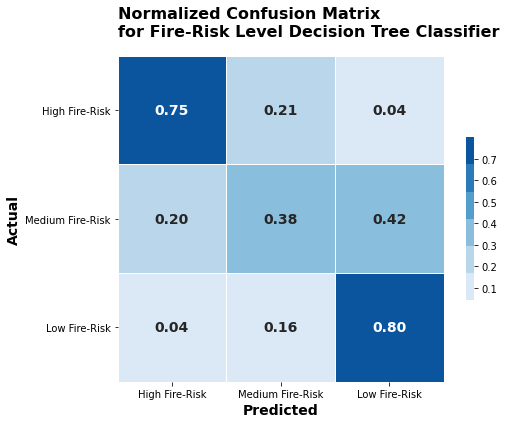

In [25]:
# Define color palette
cmap = sns.color_palette("Blues")

# Confusion Matrix
target_names = ['High Fire-Risk', 'Medium Fire-Risk', 'Low Fire-Risk']
dt_confusion_matrix = confusion_matrix(y_test, y_pred)
dt_confusion_matrix_n = dt_confusion_matrix.astype(
    'float') / dt_confusion_matrix.sum(axis=1)[:, np.newaxis]

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(dt_confusion_matrix_n, annot=True, fmt='.2f', cmap=cmap,
            xticklabels=target_names, yticklabels=target_names,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot_kws={"fontsize": 14, "fontweight": "bold"})

# Rotate y-axis labels
plt.yticks(rotation=0)

# Add title and axis labels
title_font = {'size': 16, 'weight': 'bold', 'ha': 'left'}
ax.set_title("Normalized Confusion Matrix\nfor Fire-Risk Level Decision Tree Classifier",
             fontdict=title_font, loc='left', pad=20)
plt.ylabel('Actual', fontsize=14, fontweight="bold")
plt.xlabel('Predicted', fontsize=14, fontweight="bold")

plt.show()

In [26]:
# File Output
dt_cm_file_name = 'dt_confusion_matrix.png'
dt_cm_file_path = 'Data/Data_visualization_folders/modelling_results/' + \
    dt_cm_file_name
if os.path.exists(dt_cm_file_name):
    os.remove(dt_cm_file_name)
    # Save the plot to a file
    fig.savefig(dt_cm_file_path, dpi=300, bbox_inches='tight')
else:
    # Save the plot to a file
    fig.savefig(dt_cm_file_path, dpi=300, bbox_inches='tight')

#### Confusion table

In [27]:
metrics = ['Average Validation Balanced Accuracy',
           'Average Validation Precision',
           'Average Validation Recall',
           'Average Validation F1',
           'Average Validation ROC-AUC (One vs Rest) score',
           'Test Balanced Accuracy',
           'Test Precision',
           'Test Recall',
           'Test F1',
           'Test ROC-AUC (One vs Rest) score'
           ]
Values = [dt_avg_bal_acc, dt_avg_pre_samples,
          dt_avg_rec_samples, dt_avg_f1_samples, dt_avg_roc_auc,
          test_bal_acc, test_pre_sample, test_rec_sample, test_f1_sample,
          test_roc_auc]

# Define table columns
table = PrettyTable(['Metrics', 'Decision Tree Results'])

# Add rows to table
for metric, value in zip(metrics, Values):
    table.add_row([metric, round(value, 4)])

# Print table
print(table)

+------------------------------------------------+-----------------------+
|                    Metrics                     | Decision Tree Results |
+------------------------------------------------+-----------------------+
|      Average Validation Balanced Accuracy      |         0.6652        |
|          Average Validation Precision          |         0.8157        |
|           Average Validation Recall            |         0.7759        |
|             Average Validation F1              |         0.7915        |
| Average Validation ROC-AUC (One vs Rest) score |          0.75         |
|             Test Balanced Accuracy             |         0.6428        |
|                 Test Precision                 |         0.8658        |
|                  Test Recall                   |         0.7644        |
|                    Test F1                     |         0.8034        |
|        Test ROC-AUC (One vs Rest) score        |         0.7392        |
+------------------------

In [28]:
# Create dataframe from lists
df_DT_results = pd.DataFrame(
    list(zip(metrics, Values)), columns=['Metrics', 'Decision Tree Results'])

# Print dataframe
print(df_DT_results)

                                          Metrics  Decision Tree Results
0            Average Validation Balanced Accuracy               0.665245
1                    Average Validation Precision               0.815683
2                       Average Validation Recall               0.775894
3                           Average Validation F1               0.791499
4  Average Validation ROC-AUC (One vs Rest) score               0.750004
5                          Test Balanced Accuracy               0.642797
6                                  Test Precision               0.865848
7                                     Test Recall               0.764426
8                                         Test F1               0.803432
9                Test ROC-AUC (One vs Rest) score               0.739189


In [29]:
# File Output
dt_results_file_name = 'dt_results.csv'
dt_results_file_path = 'Data/Data_visualization_folders/modelling_results/' + \
    dt_results_file_name
if os.path.exists(dt_results_file_name):
    os.remove(dt_results_file_name)
    df_DT_results.to_csv(dt_results_file_path, index=True)
else:
    df_DT_results.to_csv(dt_results_file_path, index=True)

#### ROC-AUC Curve (One vs Rest)

In [30]:
#Macro averaging: Taking fpr, tpr of each classification (one vs rest) and taking the average
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_pred_proba,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.74


In [31]:
y_test_arr = y_test.to_numpy()
n_classes = len(y_test['FIRE_RISK_1_MONTH_FORWARD_SHIFT'].unique())
classes = y_test['FIRE_RISK_1_MONTH_FORWARD_SHIFT'].unique()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.74


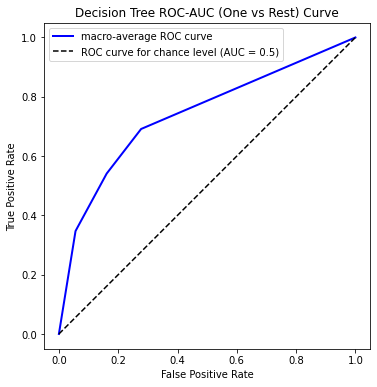

In [32]:
# Plotting ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve",
    color="blue",
    linewidth=2,
)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC-AUC (One vs Rest) Curve")
plt.legend()
plt.show()

In [33]:
# File Output
dt_roc_auc_file_name = 'dt_roc_auc_curve.png'
dt_roc_auc_file_path = 'Data/Data_visualization_folders/modelling_results/' + \
    dt_roc_auc_file_name
if os.path.exists(dt_roc_auc_file_name):
    os.remove(dt_roc_auc_file_name)
    # Save the plot to a file
    fig.savefig(dt_roc_auc_file_path, dpi=300, bbox_inches='tight')
else:
    # Save the plot to a file
    fig.savefig(dt_roc_auc_file_path, dpi=300, bbox_inches='tight')

In [34]:
dt_roc_df = pd.DataFrame({'Decision Tree False Positive Rate': fpr['macro'],
                           'Decision Tree True Positive Rate': tpr['macro']})

print(dt_roc_df.head())

   Decision Tree False Positive Rate  Decision Tree True Positive Rate
0                           0.000000                          0.000000
1                           0.001001                          0.006196
2                           0.002002                          0.012392
3                           0.003003                          0.018589
4                           0.004004                          0.024785


In [35]:
# File Output
dt_roc_file_name = 'dt_roc.csv'
dt_roc_file_path = 'Data/Data_visualization_folders/modelling_results/' + \
    dt_roc_file_name
if os.path.exists(dt_roc_file_name):
    os.remove(dt_roc_file_name)
    dt_roc_df.to_csv(dt_roc_file_path, index=True)
else:
    dt_roc_df.to_csv(dt_roc_file_path, index=True)

#### Feature importance

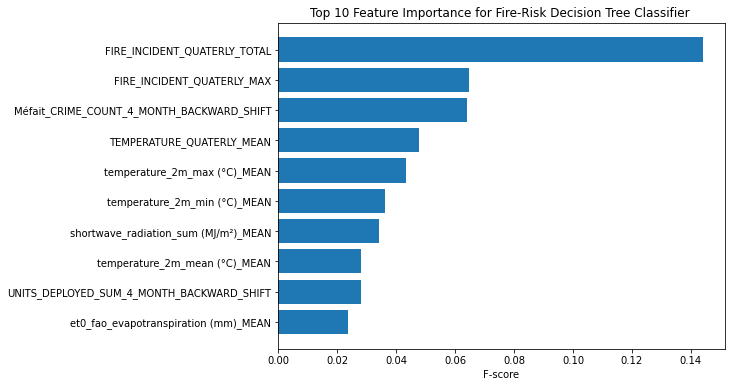

In [36]:
# Get the feature importances from the RFCClassifier model
fi = dt_model.feature_importances_

# Get the indices of the top 10 features
top_n = 10
sorted_idx = np.argsort(fi)[::-1][:top_n]

# Create a bar plot of the feature importances
fig, ax = plt.subplots(figsize=(8, 6))
plt.barh(np.array(train_df.columns)[sorted_idx][::-1], fi[sorted_idx][::-1])
plt.xlabel('F-score')
plt.title(
    'Top {} Feature Importance for Fire-Risk Decision Tree Classifier '.format(top_n))

plt.show();

In [37]:
# File Output
dt_fi_file_name = 'dt_top_10_feature_importances.png'
dt_fi_file_path = 'Data/Data_visualization_folders/modelling_results/' + \
    dt_fi_file_name
if os.path.exists(dt_fi_file_name):
    os.remove(dt_fi_file_name)
    # Save the plot to a file
    fig.savefig(dt_fi_file_path, dpi=300, bbox_inches='tight')
else:
    # Save the plot to a file
    fig.savefig(dt_fi_file_path, dpi=300, bbox_inches='tight')

In [38]:
# Get the feature importances from the DTCClassifier model
fi = dt_model.feature_importances_

n_idx = np.argsort(fi)[::-1][:]

# Create a DataFrame of the top N feature importances
df_dt_fi = pd.DataFrame({'Features': np.array(train_df.columns)[n_idx],
                          'Decision Tree Feature Importance Score': fi[n_idx]})

# Sort the DataFrame by importance in descending order
df_rfc_fi = df_dt_fi.sort_values(
    'Decision Tree Feature Importance Score', ascending=False).reset_index(drop=True)

# Print the DataFrame
df_rfc_fi.head(45)

,Features,Decision Tree Feature Importance Score
0,FIRE_INCIDENT_QUATERLY_TOTAL,0.144237
1,FIRE_INCIDENT_QUATERLY_MAX,0.064647
2,Méfait_CRIME_COUNT_4_MONTH_BACKWARD_SHIFT,0.064146
3,TEMPERATURE_QUATERLY_MEAN,0.047912
4,temperature_2m_max (°C)_MEAN,0.043242
5,temperature_2m_min (°C)_MEAN,0.036222
6,shortwave_radiation_sum (MJ/m²)_MEAN,0.034202
7,temperature_2m_mean (°C)_MEAN,0.028169
8,UNITS_DEPLOYED_SUM_4_MONTH_BACKWARD_SHIFT,0.028114
9,et0_fao_evapotranspiration (mm)_MEAN,0.023723


In [39]:
# File Output
dt_fi_list_file_name = 'dt_feature_importance.csv'
dt_fi_list_file_path = 'Data/Data_visualization_folders/modelling_results/' + \
    dt_fi_list_file_name
if os.path.exists(dt_fi_list_file_name):
    os.remove(dt_fi_list_file_name)
    df_dt_fi.to_csv(
        dt_fi_list_file_path, index=True)
else:
    df_dt_fi.to_csv(
        dt_fi_list_file_path, index=True)